In [1]:
# Generic imports
import os.path as path
import cv2 as cv2
from torchvision import transforms as tf
from glob import glob
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set data to be processed
DROOT = './0_data'

# Eyetracker
VID_SRC = path.join(DROOT, "1_rawfootage/20210406_Amsterdam_eye/2021-04-06_10-59-05.mp4")
VID_DST = path.join(DROOT, "2_procfootage/eyetracker/")

# 360-degree image
RND_SRC = path.join(DROOT, "1_rawfootage/20210406_Amsterdam_360/360_0033-ok_stitched_injected.JPG")
RND_CRP = path.join(DROOT, "2_procfootage/360-cropped.jpg")
RND_DST = path.join(DROOT, "2_procfootage/round_img/")

## Eyetracker frames
Eyetracker footage is cropped and resized for every frame, and exported. Labels for these images are created in Notebook 2. 

In [73]:
# Get eyetracker footage.
video = cv2.VideoCapture(VID_SRC)
i = 0
success = True
reserved = None

# The cut to make the images square.
cut = (1280-720)//2

# Loop over full eyetracker footage.
while success:
    success, image = video.read()
    
    if success:
        # Crop image.
        image = image[:, cut:-cut, :]
        
        # Write out.
        cv2.imwrite(path.join(EYE_DST, f"{i}.png"), image)
        i += 1
        
        reserved = image

scan = len(glob(path.join(EYE_DST, '*.png')))
print(f"Exported {i}, in dir {scan}, correct {scan==i}")

Exported 246, in dir 246, correct True


## 360-Camera exceps

Shape of original 360 image: (2896, 5792, 3)
Crop height 543, step interval 181, size 905
Cropped image to (1810, 5792, 3)
Completing circle: (1810, 6516, 3)


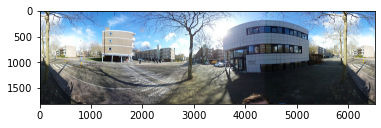

In [18]:
image = cv2.imread(RND_SRC)
or_height, or_width, channels = image.shape
print("Shape of original 360 image:", image.shape)

# Step size
assert or_height % 16 == 0
step = or_height // 16
croph = step * 3
size = step * 5
print(f"Crop height {croph}, step interval {step}, size {size}")

# Crop top and bottom parts
image = image[croph:-croph]
cv2.imwrite(RND_CRP, image)
print("Cropped image to", image.shape)

# Wrap around on left and right side to get complete circle
image = cv2.copyMakeBorder(image, 0,0,0,size-step, cv2.BORDER_WRAP)
print("Completing circle:", image.shape)

cv2.imwrite(RND_CRP, image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [19]:
!rm ./0_data/2_procfootage/round_img/*

In [20]:
i = 0
slices = []
labels = []
for y in range(0, image.shape[0]-size+step, step):
    for x in range(0, image.shape[1]-size+step, step):
        slices += [image[y:y+size, x:x+size]]
        cv2.imwrite( path.join(RND_DST, f"{i}.png"), 
                    image[y:y+size, x:x+size] )
        labels.append([i, x, y])
        i += 1

In [21]:
labels = pd.DataFrame(labels, columns=['frame', 'x', 'y'])
labels = labels.set_index('frame')

# Compensate for the upper crop
labels['y'] += 543

labels.to_csv(path.join(RND_DST, 'labels.csv'))
labels.tail()

,x,y
frame,,
187,4887,1448
188,5068,1448
189,5249,1448
190,5430,1448
191,5611,1448
